In [1]:
import pandas as pd
import covid19_module

In [2]:
df_cases_raw = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv", index_col=False)
df_deaths_raw = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv", index_col=False)
df_recoveries_raw = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv", index_col=False)

df_cases = covid19_module.preprocess_frame(df_cases_raw)
df_deaths = covid19_module.preprocess_frame(df_deaths_raw)
df_recoveries = covid19_module.preprocess_frame(df_recoveries_raw)

covid19_module.shift_to_day_zero(df_cases, df_cases)
covid19_module.shift_to_day_zero(df_deaths, df_deaths)
covid19_module.shift_to_day_zero(df_recoveries, df_recoveries)

In [3]:
top_cases = covid19_module.top_countries(df_cases_raw)
top_deaths = covid19_module.top_countries(df_deaths_raw)
print("Latest update: ", df_cases_raw.columns[-1], "\n")
covid19_module.print_mortality_rates(df_cases, df_deaths, top_deaths)

Latest update:  4/3/20 

Mortality rates for the countries with the highest number of deaths
-------------------------------------------------------------------
Italy ( 14681  deaths ):  12.3 %
Spain ( 11198  deaths ):  9.4 %
US ( 7087  deaths ):  2.6 %
France ( 6520  deaths ):  10.0 %
United Kingdom ( 3611  deaths ):  9.3 %
China ( 3326  deaths ):  4.0 %
Iran ( 3294  deaths ):  6.2 %
Netherlands ( 1490  deaths ):  9.4 %
Germany ( 1275  deaths ):  1.4 %
Belgium ( 1143  deaths ):  6.8 %


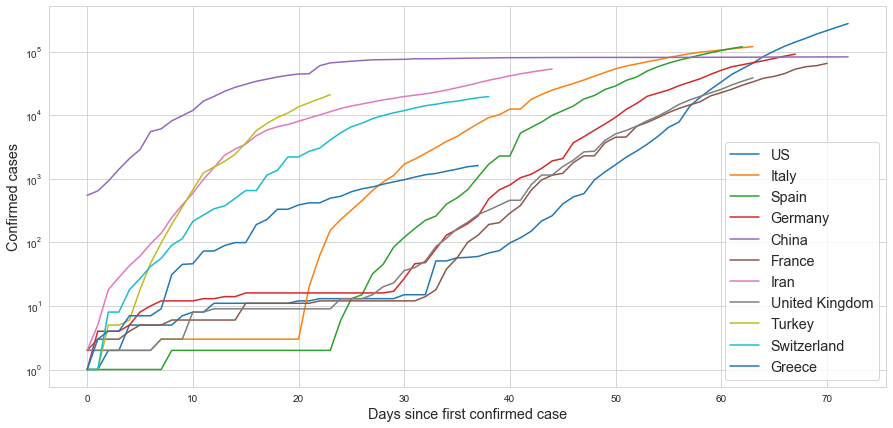

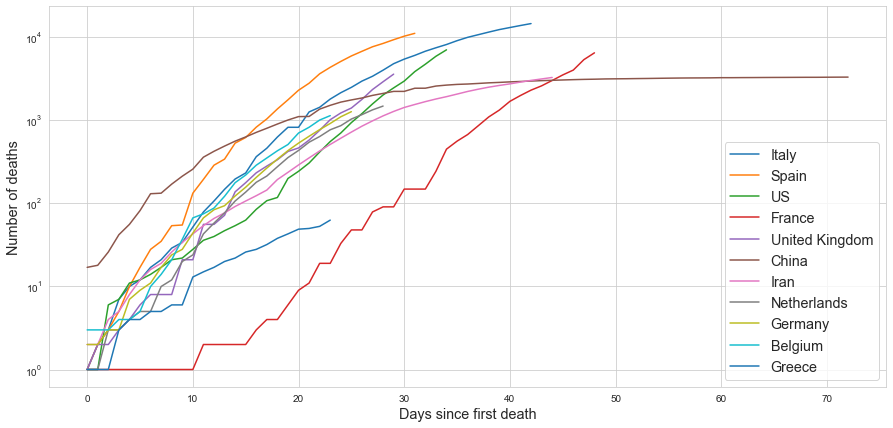

In [4]:
#%matplotlib notebook
covid19_module.plot_growth(df_cases, top_cases, "confirmed")
covid19_module.plot_growth(df_deaths, top_deaths, "deaths")